In [24]:
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt


def range_corrected_signal(signal_raw, opar_range, opar_alt, bck_correction = False):
    '''
    Fontionc permet de retrouver un signal corrigé de la distance à l'instrument et du fond ciel 
    Input: 
        signal_raw: raw signal (MHz) without any correction
        opar_range: range in meters 
        opar_alt: altitude in meters
        bck_correction: False = non corriger, True = corriger
    Output:
        Signal corrigé 
    '''
    if bck_correction == False:
        rcs = signal_raw * (opar_range**2) #MHz.m^2
    else:
        idx = ((opar_alt>=80000)&(opar_alt<=100000))
        signal_bck = signal_raw.isel(range=idx)
        bck = signal_bck.mean(("range"))
        rcs = (signal_raw - bck)*(opar_range**2)
    return rcs


def get_altitude_reference(zbottom, ztop, altitude_total):
    '''
    Fonction permet de retrouver la position de l'altitude référence dans le vecteur de l'altitude et la valeur de altitude référence.
    Input:
        zbottom: le borne bas de l'intervale
        ztop: le borne haut de l'intervale
        altitude_total: le vecteur total de l'altitude
    Output:
        la valeur de l'altitude et son indexe dans le vecteur total
    '''
    def arg_median(a):
        '''
        Fonction permet de retrouver la position médiane de la zone de référence de l'altitude
        Input: 
            a = l'intervale de l'altitude où se trouve la zone de référence 
        Ouput:
            Indexe de la position dans cet intervale
        '''
        if len(a) % 2 == 1:
            return np.where(a == np.median(a))[0][0]
        else:
            l,r = len(a) // 2 - 1, len(a) // 2
            left = np.partition(a, l)[l]
            right = np.partition(a, r)[r]
            return np.where(a == left)[0][0]

    interval_ref = altitude_total[(altitude_total >= zbottom) & (altitude_total <= ztop)] 
    idxref = arg_median(interval_ref)
    zref = interval_ref[idxref]
    idxref_in_total = np.where(altitude_total == zref)[0][0]
    return zref, idxref_in_total
    

In [2]:
### Lire et sortir des données brutes: range(km), channel, signal     
instr = "LIO3T"
oparpath = Path('/home/nmpnguyen/OPAR/', instr+'.daily/2019-01-17.nc4')
print(oparpath)
opar = xr.open_dataset(oparpath)
opalt = opar['range'].values*1e3 + 2160

if instr == 'LIO3T':
    wl = 0.532
    oparraw = opar.sel(channel='00532.p')#.isel(time=100)
    oparraw2 = opar.sel(channel='00532.p')+opar.sel(channel='00532.s')
else:
    wl = 0.355
    oparraw = opar.sel(channel='00355.o.Low')
    oparraw2 = opar.sel(channel='00355.o.Verylow')
    
### Range corrected signal 
rep1 = range_corrected_signal(oparraw, opar['range'].values*1e3, opar['range'].values*1e3+2160, True)
rep2 = range_corrected_signal(oparraw2, opar['range'].values*1e3, opar['range'].values*1e3+2160, True)

### Lire et sortir la Pression et la Temperature  
oparsimulpath = Path('/homedata/nmpnguyen/OPAR/Processed/', instr, oparpath.name.split('.')[0]+'_simul.pkl')
print(oparsimulpath)
oparsimul = pd.read_pickle(oparsimulpath)
pression = oparsimul['pression'].unstack(level=1)
ta = oparsimul['ta'].unstack(level=1)

print(len(opalt))
opalt = opalt[:pression.shape[1]] 
print(len(opalt))

/home/nmpnguyen/OPAR/LIO3T.daily/2019-01-17.nc4
/homedata/nmpnguyen/OPAR/Processed/LIO3T/2019-01-17_simul.pkl
16380
16380


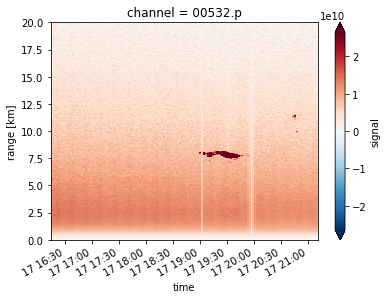

In [3]:
rep1['signal'].plot(x='time', y='range', robust=True, ylim=(0, 20))

In [4]:
# ### Plot 1 profile
# print(opar['time'])

# f, ax = plt.subplots()
# rep1.sel(time='2019-01-17T16:27:04.000000000')['signal'].plot(y='range', ax=ax, label='with filter')
# ax2 = ax.twiny()
# oparraw.sel(time='2019-01-17T16:27:04.000000000')['signal'].plot(y='range', ax=ax2, label='without filter')
# # ax.plot(rcs[10,:], data['range'].values, label='rcs-bck')
# ax.set_ylim(0, 20)
# ax.legend()

In [5]:
'''
1. Calculer le profil Pr2_z0 = Pr2[z]/Pr2[z0] puis calculer la valeur de son intégrale etre zmin et zmax
'''
### Determiner z0
zbottom = 5500
ztop = 7500
Z0, idx_ref = get_altitude_reference(zbottom, ztop, opalt)
zintervalle = np.where((opalt >= zbottom) & (opalt <= ztop))[0]


t = 100
Pr2_Z0 = rep1.isel(time=t)/rep1.isel(range=idx_ref, time=t)

Pr2_integ = 0; Pr2_integ_v2 = 0
for z in zintervalle[:-1]:
    Pr2_integ = Pr2_integ + Pr2_Z0.isel(range=z)['signal'].values*(opalt[z+1]-opalt[z])
    Pr2_integ_v2 = Pr2_integ_v2 + rep1.isel(time=t, range=z)['signal'].values*(opalt[z+1]-opalt[z])
    
Pr2_integM = np.mean(Pr2_Z0['signal'][zintervalle])


In [8]:
'''
2. Calculer le profil BetaMol[z]*Tr2(AlphaMol(z))[z0] 
Et calculer son integrale entre zmin et zmax
'''
def get_backscatter_mol(p, T, w):
    '''
    Fonction permet de calculer le coef. de backscatter moléculaire 
    p(Pa), T(K), w(um)
    '''
    k = 1.38e-23
    betamol = (p/(k*T) * 5.45e-32 * (w/0.55)**(-4.09))
    alphamol = betamol/0.119
    return alphamol, betamol

    '''
    Cette fonction permet de calculer la retrodiffusion attenuee à partir de zref, pour 1D
    '''
pres = pression.iloc[t,:].values
temp = ta.iloc[t,:].values
AlphaMol, BetaMol = get_backscatter_mol(pres, temp, wl)
print(BetaMol)

def get_backscatter_mol_attn_v1(alphamol, betamol, alt, idxref):
    Tr = betamol[idxref:].copy() #np.zeros_like(BetaMol[idx_ref:])
    Tr2 = np.zeros_like(betamol[idxref:])

    for i,j in zip(range(1, Tr2.shape[0]),range(idxref+1, len(alt))):
        Tr[i] = Tr[i-1] + alphamol[i]*(alt[j]-alt[j-1])
        Tr2[i] = np.exp(-2*Tr[i])

    betamol_Z0 = betamol.copy() #np.ones_like(BetaMol)   
    betamol_Z0[idxref+1:] = betamol[idxref+1:]*Tr2[1:]
#     print(betamol_Z0[idxref])  
    return betamol_Z0, Tr


# '''
# Cette fonction permet de calculer la retrodiffusion attenuee à partir de zref , pour 2D
# '''
# AlphaMol, BetaMol = get_backscatter_mol(pression.values, ta.values, wl)


# def get_backscatter_mol_attn_v1(alphamol, betamol, alt, idxref):

#     Tr = betamol[:,idxref:].copy() #np.zeros_like(BetaMol[idx_ref:])
#     Tr2 = np.zeros_like(betamol[:,idxref:])

#     for i,j in zip(range(1, Tr2.shape[1]),range(idxref+1, len(alt))):
#         Tr[:,i] = Tr[:,i-1] + alphamol[:,i]*(alt[j]-alt[j-1])
#         Tr2[:,i] = np.exp(-2*Tr[:,i].astype(float))

#     betamol_Z0 = betamol.copy() #np.ones_like(BetaMol)   
#     betamol_Z0[:,idxref+1:] = betamol[:,idxref+1:]*Tr2[:,1:] 
#     return betamol_Z0


def get_backscatter_mol_attn_v2(alphamol, betamol, alt):
    '''
    Cette fonction permet de calculer la retrodiffusion attenuee à partir de l'altitude de l'instrument
    '''
    Tr = np.zeros_like(betamol)
    Tr2 = np.zeros_like(betamol)
    
    for i in range(1, range(1, Tr2.shape[1])):
        Tr[:,i] = Tr[:,i-1] + alphamol[:,i]*2*(alt[i]-alt[i-1])
        Tr2[:,i] = np.exp(-2*Tr[:,i])
        
    betamol_Z0 = betamol*Tr2        
    return betamol_Z0, Tr


def get_backscatter_mol_attn_v3(alphamol, betamol, alt):
    '''
    Cette fonction permet de calculer la retrodiffusion attenuee à partir de l'altitude de l'instrument
    '''
    Tr = np.zeros_like(betamol)
    Tr2 = np.zeros_like(betamol)
    
    for i in range(1, len(Tr)):
        Tr[i] = Tr[i-1] + alphamol[i]*(alt[i]-alt[i-1])
        Tr2[i] = np.exp(-2*Tr[i])
        
    betamol_Z0 = betamol*Tr2        
    return betamol_Z0, Tr


In [368]:
# tr = np.zeros_like(BetaMol)
# tr2 = np.zeros_like(BetaMol)

# for i,j in zip(range(1, tr2.shape[1]),range(idx_ref+1, len(opalt))):
#     tr[:,i] = tr[:,i-1] + AlphaMol[:,i]*(opalt[j]-opalt[j-1])
#     tr2[:,i] = np.exp(-2*tr[:,i].astype(float))

# print(tr2)
# # betamol_Z0 = betamol.copy() #np.ones_like(BetaMol)   
# # betamol_Z0[:,idxref+1:] = betamol[:,idxref+1:]*Tr2[:,1:] 


In [13]:
BetaMol_Z0, Tr= get_backscatter_mol_attn_v1(AlphaMol, BetaMol, opalt, idx_ref)
BetaMol_Z0_v3, Tr_v3= get_backscatter_mol_attn_v3(AlphaMol, BetaMol, opalt)
# BetaMol_Z0_v2, Tr_v2= get_backscatter_mol_attn_v2(AlphaMol, BetaMol, opalt)

print(BetaMol_Z0, BetaMol_Z0_v3)

BetaMol_integ = 0; BetaMol_integ_v2 = 0; BetaMol_integ_v3 = 0
for z in zintervalle[:-1]:
    BetaMol_integ = BetaMol_integ + BetaMol_Z0[z]*(opalt[z+1]-opalt[z]) 
#     BetaMol_integ_v2 = BetaMol_integ_v2 + BetaMol_Z0_v2[z]*(opalt[z+1]-opalt[z]) 
#     BetaMol_integ_v3 = BetaMol_integ_v3 + BetaMol_Z0_v3[z]*(opalt[z+1]-opalt[z]) 
    
# BetaMol_integM = np.mean(BetaMol_Z0[zintervalle])
# BetaMol_integ_v2 = np.mean(BetaMol_Z0_v2[zintervalle])
BetaMol_integ_v3 = np.mean(BetaMol_Z0_v3[zintervalle])

# print(BetaMol_integ, BetaMol_integ_v3) #, BetaMol_integ_v2

[ 1.23384832e-06  1.23291230e-06  1.23197604e-06 ... -5.60676698e-08
 -5.60740249e-08 -5.60803802e-08] [ 0.00000000e+00  1.23272071e-06  1.23159332e-06 ... -5.63323428e-08
 -5.63387567e-08 -5.63451708e-08]


In [8]:
'''
3. Diviser l'un par l'autre pour obtenir cRF
'''
cRF = (BetaMol_integ/Pr2_integ)#.reshape(-1,1)
Pr2_integ_v2 = rep1.isel(time=t, range=zintervalle)['signal'].mean().values
# print(Pr2_integ_v2)
# cRF_v2 = (BetaMol_integ_v2/Pr2_integ_v2).reshape(-1,1)
cRF_v3 = (BetaMol_integ_v3/Pr2_integ_v2)#.reshape(-1,1)

print(cRF, cRF_v3)

7.982652898110458e-07 6.482501254653961e-17


In [9]:
'''
4. Normaliser les profils mesures par cRF
'''
# print(cRF)
# Pr2_norm = rep1.isel(time=t)['signal'].values*cRF
Pr2_norm = Pr2_Z0['signal'].values*cRF
# Pr2_norm_v2 = rep1.isel(time=t)['signal'].values*cRF_v2 #Pr2_Z0['signal'].values*cRF_v2 #
Pr2_norm_v3 = rep1.isel(time=t)['signal'].values*cRF_v3 #Pr2_Z0['signal'].values*cRF_v3 #
print(Pr2_norm_v3)


[ 0.00000000e+00  2.70782358e-11  1.09742335e-10 ...  4.76709900e-09
 -9.73340451e-07 -9.73459314e-07]


Text(0.5, 0.98, 'zmin = 5500, zmax = 7500, z0 = 6495.0')

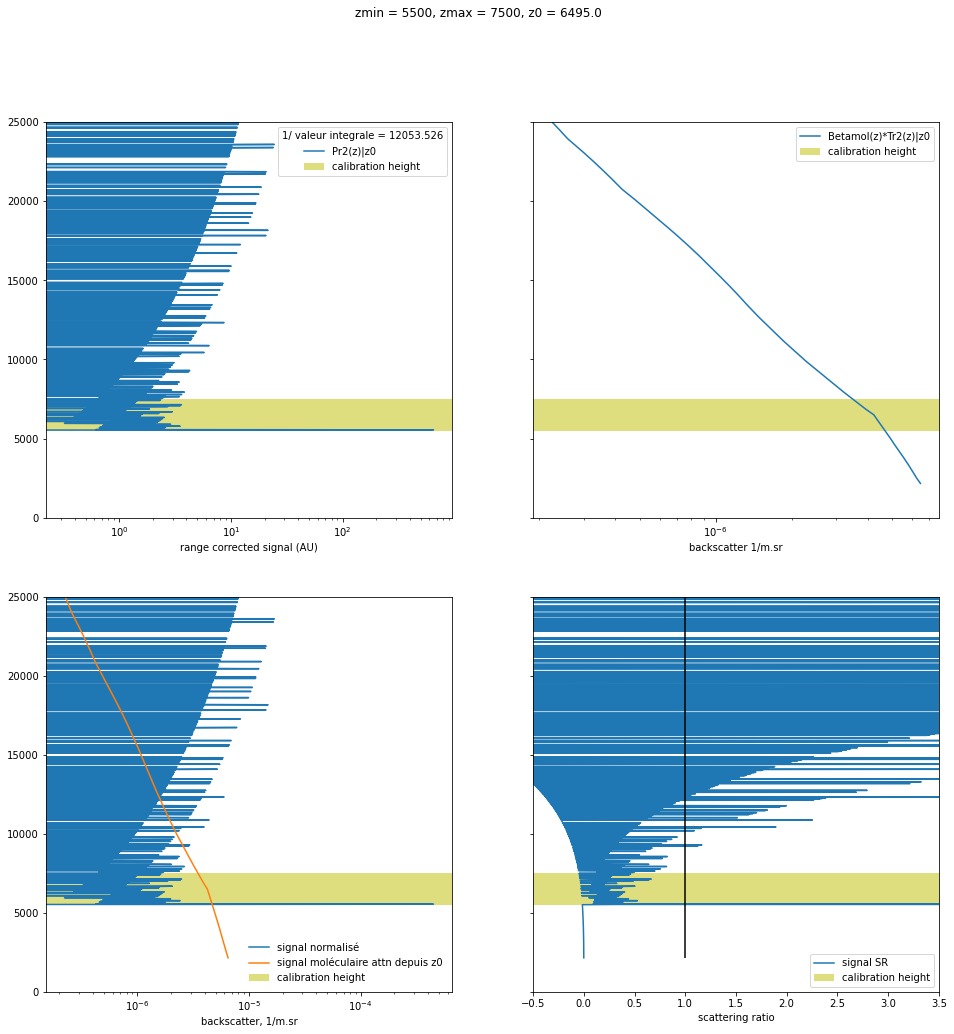

In [309]:
# '''
# 5. Plot un profil normalisé et moléculaire
# '''
fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[16,16], sharey=True)#

ax.semilogx(Pr2_Z0['signal'].values[:len(opalt)], opalt, label='Pr2(z)|z0')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
leg = ax.legend()
leg.set_title(f'1/ valeur integrale = {round(Pr2_integ,3)}')
ax.set(xlabel='range corrected signal (AU)')
ax.set_ylim(0, 25000)
# ax.set_xlim(1e-1, 2)

ax2.semilogx(BetaMol_Z0[10,:len(opalt)], opalt, label='Betamol(z)*Tr2(z)|z0')
ax2.set(xlabel='backscatter 1/m.sr')
ax2.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
leg2 = ax2.legend()
# leg2.set_title(f'2/ valeur integrale = {round(BetaMol_integ,3)}')
# ax2.set_xlim(1e-8, 2e-6)

ax3.semilogx(Pr2_norm[10,:len(opalt)], opalt, label='signal normalisé')
# ax3.semilogx(Pr2_norm_v2[:len(opalt)], opalt, label='signal normalisé, double extinction')
ax3.semilogx(BetaMol_Z0[10,:len(opalt)], opalt, label='signal moléculaire attn depuis z0')
# ax3.semilogx(BetaMol_Z0_v2, opalt, label='signal moleculaire attn depuis sol')
ax3.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
# ax.set(title='5.916e-11')
leg3 = ax3.legend(loc='best', frameon=False)
# leg3.set_title(f'4/ cRF = {cRF}')
ax3.set(xlabel='backscatter, 1/m.sr')
# ax3.set_xlim(1e-8, 2e-6)

ax4.plot(Pr2_norm[10,:len(opalt)]/BetaMol_Z0[10,:len(opalt)], opalt, label='signal SR')
# ax4.plot(Pr2_norm_v2[:len(opalt)]/BetaMol_Z0_v2, opalt, label='signal SR, double extinction')
ax4.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax4.vlines(1, ymin=opalt.min(), ymax=opalt.max(), color='k', zorder=10)
# ax.set(title='5.916e-11')
leg4 = ax4.legend()
# leg4.set_title(f'4/ cRF = {cRF}')
ax4.set_xlim(-0.5, 3.5)
ax4.set(xlabel = 'scattering ratio')

plt.suptitle(f'zmin = {zbottom}, zmax = {ztop}, z0 = {opalt[idx_ref]}')

standard deviation: 5.679198668035687e-07
residual: -0.00016950027642188107


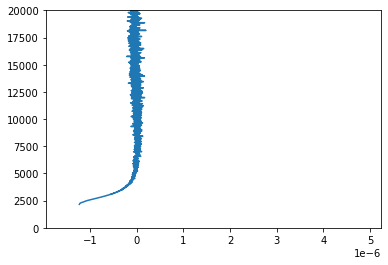

In [137]:
'''
6. LE RESIDUE À TESTER
'''
import sys
residual = 0
for z in range(len(opalt)):
    residual = residual + (Pr2_norm[z] - BetaMol_Z0[z])


# with open('/home/nmpnguyen/residus_by_profil.txt', 'w') as f:
#     print(residual)
    
# f.close()

residus = Pr2_norm - BetaMol_Z0

fig, ax = plt.subplots()
ax.plot(residus, opalt)
ax.set_ylim(0,20000)

print(f'standard deviation: {np.std(residus[(opalt>5)&(opalt>20)])}')
print(f'residual: {residual}')

<ipython-input-15-4fdda56fdd6e>:69: RuntimeWarning: invalid value encountered in true_divide
  ax8.plot(Pr2_norm_v3/BetaMol_Z0_v3, opalt)#, label='signal SR, double extinction')


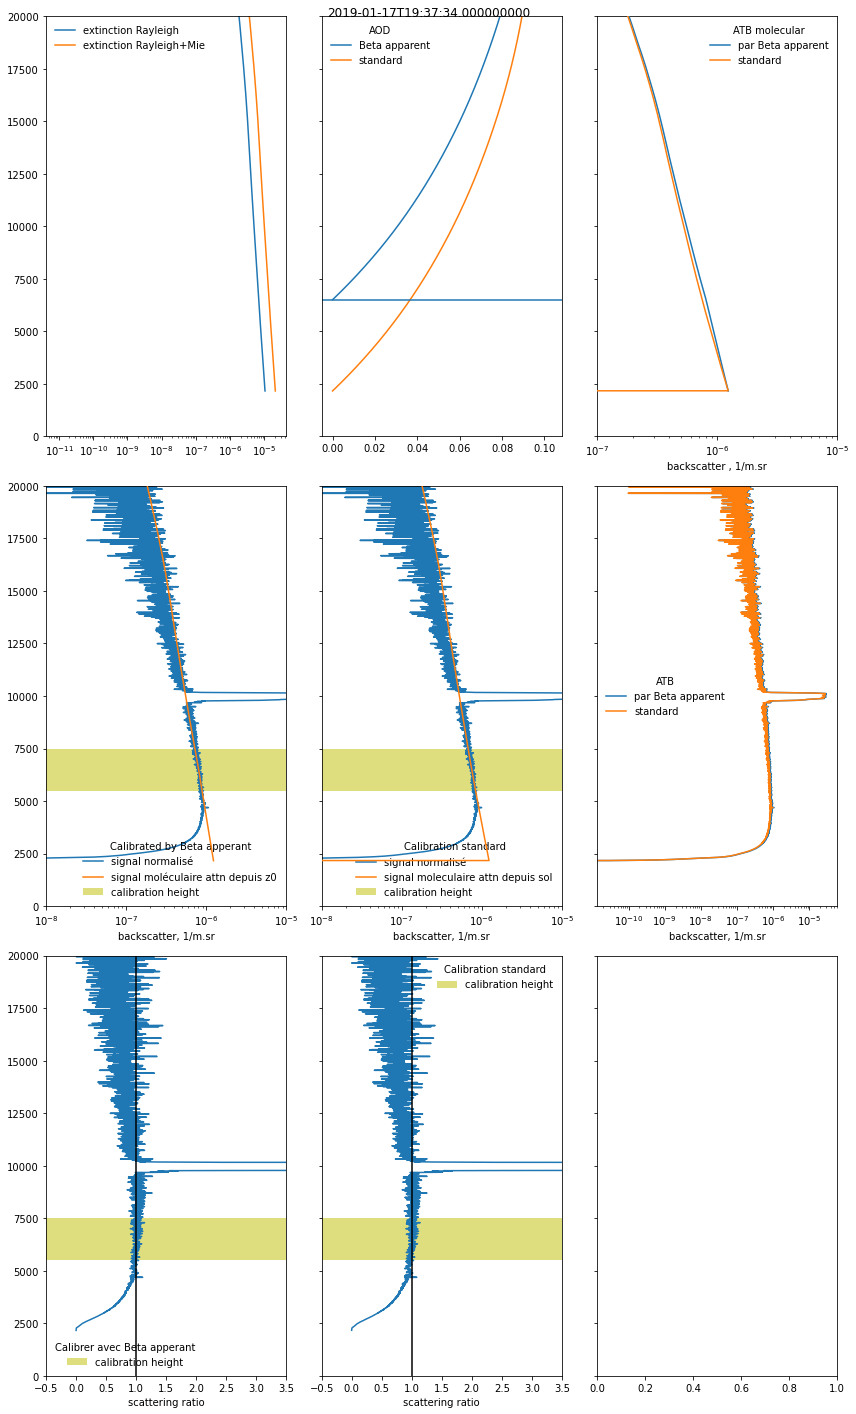

In [15]:
fig, ((ax,ax6, ax10), (ax2, ax7, ax9), (ax4, ax8, ax5)) = plt.subplots(nrows=3, ncols=3, figsize=[12,20], sharey=True)

### ------------------LIGNE 1------------------
ax.semilogx(AlphaMol, opalt, label='extinction Rayleigh')
ax.semilogx(AlphaMol*2, opalt, label='extinction Rayleigh+Mie')
# ax.semilogx(BetaMol[opalt<20000], opalt[1:1189], label='molecular backscatter')
ax.set_ylim(0, 20000)
ax.legend(loc='best', frameon=False)
# ax.set_xlim(1e-8, 1e-5)

ax6.plot(Tr, opalt[idx_ref:], label='Beta apparent')
# ax6.plot(Tr_v2, opalt, label='molecular extinction+Mie')
ax6.plot(Tr_v3, opalt, label='standard')
ax6.axhline(y=opalt[idx_ref])
ax6.legend(loc='best', frameon=False, title='AOD')
ax6.set_ylim(0, 20000)
# ax6.set_xlim(1e-8, 1e-5)

ax10.semilogx(BetaMol_Z0, opalt, label='par Beta apparent', zorder=10)
# ax10.semilogx(Pr2_norm_v2, opalt, label='par Rayleigh+Mie')
ax10.semilogx(BetaMol_Z0_v3, opalt, label='standard', zorder=10)
ax10.legend(loc='best', frameon=False, title='ATB molecular')
ax10.set(xlabel='backscatter , 1/m.sr')
ax10.set_xlim(1e-7, 1e-5)

### ------------------LIGNE 2------------------
ax2.semilogx(Pr2_norm, opalt, label='signal normalisé')
ax2.semilogx(BetaMol_Z0, opalt, label='signal moléculaire attn depuis z0', zorder=10)
ax2.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax2.legend(loc='best', frameon=False, title='Calibrated by Beta apperant')
ax2.set(xlabel='backscatter, 1/m.sr')
ax2.set_xlim(1e-8, 1e-5)

# ax3.semilogx(Pr2_norm_v2, opalt, label='signal normalisé')
# ax3.semilogx(BetaMol_Z0_v2, opalt, label='signal moleculaire attn depuis sol', zorder=10)
# ax3.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
# leg3 = ax3.legend(loc='best', frameon=False, title='Calibrated by extinction Rayleigh+Mie')
# ax3.set(xlabel='backscatter, 1/m.sr')
# ax3.set_xlim(1e-8, 1e-5)

ax9.semilogx(Pr2_norm, opalt, label='par Beta apparent')
# ax9.semilogx(Pr2_norm_v2, opalt, label='par Rayleigh+Mie')
ax9.semilogx(Pr2_norm_v3, opalt, label='standard')
ax9.legend(loc='best', frameon=False, title = 'ATB')
ax9.set(xlabel='backscatter, 1/m.sr')

ax7.semilogx(Pr2_norm_v3, opalt, label='signal normalisé')
ax7.semilogx(BetaMol_Z0_v3, opalt, label='signal moleculaire attn depuis sol', zorder=10)
ax7.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax7.legend(loc='best', frameon=False, title='Calibration standard')
ax7.set(xlabel='backscatter, 1/m.sr')
ax7.set_xlim(1e-8, 1e-5)

### ------------------LIGNE 3------------------
ax4.plot(Pr2_norm/BetaMol_Z0, opalt)#, label='signal SR') 
ax4.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax4.axvline(1, color='k', zorder=10)
ax4.legend(loc='best', frameon=False, title='Calibrer avec Beta apperant')
ax4.set(xlabel = 'scattering ratio')
ax4.set_xlim(-0.5, 3.5)

# ax5.plot(Pr2_norm_v2/BetaMol_Z0_v2, opalt)#, label='signal SR, double extinction')
# ax5.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
# ax5.axvline(1, color='k', zorder=10)
# ax5.legend(loc='best', frameon=False, title='Calibrer avec extinction Rayleigh+Mie')
# ax5.set(xlabel = 'scattering ratio')
# ax5.set_xlim(-0.5, 3.5)

ax8.plot(Pr2_norm_v3/BetaMol_Z0_v3, opalt)#, label='signal SR, double extinction')
ax8.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax8.axvline(1, color='k', zorder=10)
ax8.legend(loc='best', frameon=False, title='Calibration standard')
ax8.set(xlabel = 'scattering ratio')
ax8.set_xlim(-0.5, 3.5)

plt.savefig(Path('/homedata/nmpnguyen/OPAR/Processed/RF/',instr, 'study_case_'+str(wl)+oparpath.name.split('.')[0]+'.png'))
plt.suptitle(f'{str(opar.isel(time=t).time.values)}')
plt.tight_layout()


In [366]:
'study_case_'+str(wl)+oparpath.name.split('.')[0]

'study_case_0.5322019-01-17'

In [203]:
'''
7. Sortir en NetCDF
'''


'\n7. Sortir en NetCDF\n'

(0.0, 20.0)

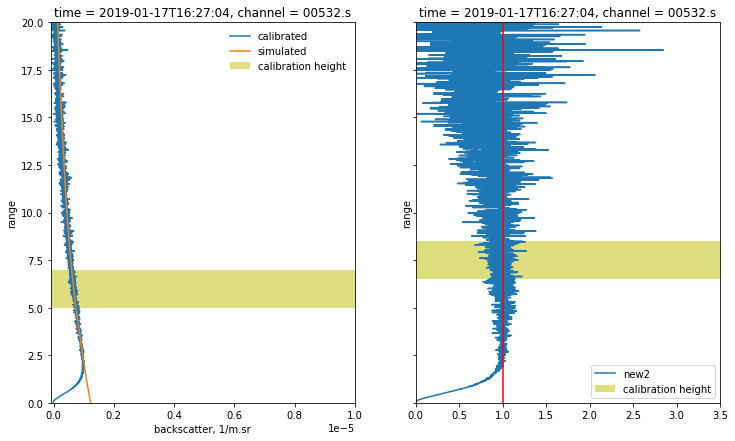

In [328]:
new1 = xr.open_dataset("/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-01-17RF_v1.nc")
new2 = xr.open_dataset("/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-17__v2.nc")
new3 = xr.open_dataset("/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-05-27RF_v1.nc")
new4 = xr.open_dataset("/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-02-19RF_v1.nc")
# print(new4.attrs['calibration height'][0])

# N = np.int_(np.linspace(0, len(new1['time'])-1, 20))
# f, axs = plt.subplots(ncols=5, nrows=4, figsize=[15,15], sharey=True)
# for n, ax in enumerate(axs.flatten()):
#     (new2.isel(time=N[n], channel=1)['calibrated']/new2.isel(time=N[n], channel=1)['simulated']).plot(y='range', label='calibrated', ax=ax)
# #     new1.isel(time=N[n], channel=1)['simulated'].plot(y='range', linestyle = '--', label='simulated', ax=ax)
# # new1.isel(time=N[n], channel=1)['calibrated'].plot(y='range', label='calibrated s', ax=ax)
# # new1.isel(time=N[n], channel=1)['simulated'].plot(y='range', linestyle = '--', label='simulated s', ax=ax)
#     ax.axhspan(8.5, 6.5, color='y', alpha=0.5, lw=0, label='calibration height')
#     ax.axvline(1, color='r', zorder=10)
# #     ax.legend()
#     ax.set_ylim(0,20)
#     ax.set_xlim(0, 4)

channelnb = 1
fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=[12,7], sharey=True)#
# new2.isel(channel=channelnb, time=n)['calibrated'].plot(y='range', ax=ax3, label='calibrated')
# new2.isel(channel=channelnb, time=n)['simulated'].plot(y='range', ax=ax3, label='simulated')
new1.isel(channel=channelnb, time=n)['calibrated'].plot(y='range', ax=ax3, label='calibrated')
new1.isel(channel=channelnb, time=n)['simulated'].plot(y='range', ax=ax3, label='simulated')
# ax3.axhspan(new2.attrs['calibration height'][0]/1e3, new2.attrs['calibration height'][1]/1e3, color='y', alpha=0.5, lw=0, label='calibration height')
ax3.axhspan(new1.attrs['calibration height'][0]/1e3, new1.attrs['calibration height'][1]/1e3, color='y', alpha=0.5, lw=0, label='calibration height')
leg3 = ax3.legend(loc='best', frameon=False)
ax3.set(xlabel='backscatter, 1/m.sr')
ax3.set_ylim(0,20)
ax3.set_xlim(-1e-7, 1e-5)
# (new2.isel(channel=channelnb, time=n)['calibrated']/new2.isel(channel=channelnb, time=n)['simulated']).plot(y='range', ax=ax4, label='new2')
(new1.isel(channel=channelnb, time=n)['calibrated']/new1.isel(channel=channelnb, time=n)['simulated']).plot(y='range', ax=ax4, label='new2')
ax4.axvline(1, zorder=10, color='r')
ax4.axhspan(new2.attrs['calibration height'][0]/1e3, new2.attrs['calibration height'][1]/1e3, color='y', alpha=0.5, lw=0, label='calibration height')
ax4.legend()
ax4.set_xlim(0, 3.5)
ax4.set_ylim(0,20)


In [155]:
import scipy.stats as sts

def CorrelationPlot(new):
# print(np.where((new["range"]+2.160 > 7) & (new["range"]+2.160 < 20)))
    statdt = []
    for i in range(0, len(new["time"])):
    #     print(f'{new["time"][i].values}')
    #     print(f'LINREGRESS: {sts.linregress(new.isel(time=i, channel=0)["calibrated"].values, new.isel(time=i, channel=0)["simulated"].values)}')
    #     print(f'CORRELATION: {np.corrcoef(new.isel(time=i, channel=0)["calibrated"].values, new.isel(time=i, channel=0)["simulated"].values)[0,1]}')
        xstat = new.isel(time=i, channel=0)["simulated"][(new["range"]+2.160 > 5) & (new["range"]+2.160 < 20)]
        ystat = new.isel(time=i, channel=0)["calibrated"][(new["range"]+2.160 > 5) & (new["range"]+2.160 < 20)]
        statdt.append(np.corrcoef(xstat, ystat)[0,1])

    return statdt


def residus_alt(new, channelnb):
    limite = np.where((new['range']>5)&(new['range']<20))[0]
    residue = np.nansum(new.isel(channel=1, range=limite)['calibrated']-new.isel(channel=1, range=limite)['simulated'], axis=1)
    residues = np.nansum([new.isel(channel=channelnb)['calibrated'],-new.isel(channel=channelnb)['simulated']], axis=0)
    residues = np.nanmean(residues, axis=1)
    return residue, residues



In [174]:
# stat2 = CorrelationPlot(new2)
# stat3 = CorrelationPlot(new3)
# stat4 = CorrelationPlot(new4)

stat2 = residus_alt(new2, 1)

stat2 = residus_alt(new2, 1)[0]
stat3 = residus_alt(new3, 1)[0]
stat4 = residus_alt(new4, 1)[0]


153 153
[-1.06305801e-04 -1.09204220e-04 -1.11549457e-04 -1.24338991e-04
 -1.13730095e-04 -1.08281700e-04 -1.17394836e-04 -1.01137596e-04
 -1.10938576e-04 -1.12747151e-04 -1.07274778e-04 -1.09213859e-04
 -1.15863052e-04 -1.10881750e-04 -1.16226199e-04 -1.06691903e-04
 -1.04892632e-04 -1.02712650e-04 -1.18067825e-04 -1.05916420e-04
 -1.09947412e-04 -1.08881674e-04 -1.19081872e-04 -1.11909170e-04
 -1.13482184e-04 -1.09970777e-04 -1.14526297e-04 -1.09294097e-04
 -1.03415234e-04 -1.07868848e-04 -1.04079857e-04 -1.12874116e-04
 -1.11067882e-04 -1.11776828e-04 -1.14832467e-04 -1.11655140e-04
 -1.10748072e-04 -1.11332534e-04 -1.15113542e-04 -1.17923244e-04
 -1.04134680e-04 -1.10539422e-04 -1.12682896e-04 -1.21153112e-04
 -1.12752956e-04 -1.11173989e-04 -1.11620793e-04 -1.11978020e-04
 -1.05811602e-04 -1.14213283e-04 -1.12293996e-04 -1.12942889e-04
 -1.12975945e-04 -1.19146053e-04 -1.14068347e-04 -1.17341788e-04
 -1.05723372e-04 -1.09346917e-04 -1.13873006e-04 -1.18446166e-04
 -1.13962659e-04 

<xarray.DataArray 'simulated' (range: 16380)>
array([ 1.262189e-06,  1.260908e-06,  1.259628e-06, ..., -9.569222e-08,
       -9.570890e-08, -9.572558e-08])
Coordinates:
    time     datetime64[ns] 2019-09-10T17:42:22
  * range    (range) float64 0.0 0.0075 0.015 0.0225 ... 122.8 122.8 122.8 122.8
    channel  <U7 '00532.s'


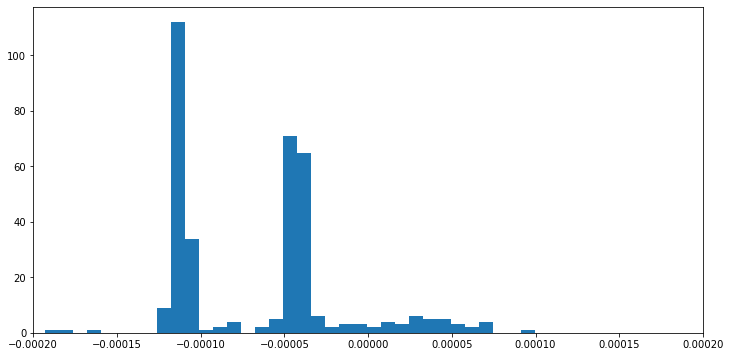

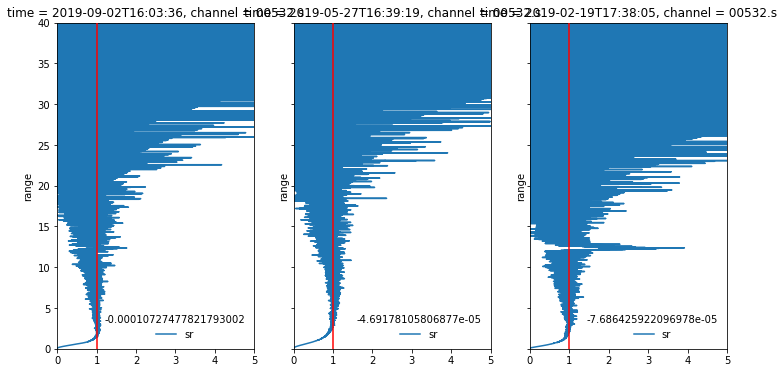

In [181]:
# f, (ax2, ax3, ax4) = plt.subplots(figsize=[12,6], ncols=3)
# (n2, bins2, patches2 )= ax2.hist(stat2, bins=100, density=False,
#                              label=str(new2.attrs))
# (n3, bins3, patches3 )= ax3.hist(stat3, bins=100, density=False,
#                              label=str(new3.attrs))
# (n4, bins4, patches4 )= ax4.hist(stat4, bins=100, density=False,
#                              label=str(new4.attrs))

ff, ax = plt.subplots(figsize=[12,6])
ax.hist(np.concatenate((stat2, stat3, stat4)), bins=100, density=False)
ax.set_xlim(-2e-4, 2e-4)

f, (ax2, ax3, ax4) = plt.subplots(figsize=[12,6], ncols=3, sharey=True)
# new2.isel(time=10, channel=1)['calibrated'].plot(y='range', ax=ax2, label='calibrated')
# new2.isel(time=10, channel=1)['simulated'].plot(y='range', ax=ax2, label='simulated')
(new2.isel(time=10, channel=1)['calibrated']/new2.isel(time=10, channel=1)['simulated']).plot(y='range', ax=ax2, label='sr')
ax2.axvline(1, color='r', zorder=10)
ax2.legend(frameon=False, title=str(stat2[10]))
ax2.set_ylim(0,40)
ax2.set_xlim(0,5)
# new3.isel(time=10, channel=1)['calibrated'].plot(y='range', ax=ax3, label='calibrated')
# new3.isel(time=10, channel=1)['simulated'].plot(y='range', ax=ax3, label='simulated')
(new3.isel(time=10, channel=1)['calibrated']/new3.isel(time=10, channel=1)['simulated']).plot(y='range', ax=ax3, label='sr')
ax3.axvline(1, color='r', zorder=10)
ax3.legend(frameon=False, title=str(stat3[10]))
ax3.set_ylim(0,40)
ax3.set_xlim(0,5)
# new4.isel(time=10, channel=1)['calibrated'].plot(y='range', ax=ax4, label='calibrated')
# new4.isel(time=10, channel=1)['simulated'].plot(y='range', ax=ax4, label='simulated')
(new4.isel(time=10, channel=1)['calibrated']/new4.isel(time=10, channel=1)['simulated']).plot(y='range', ax=ax4, label='sr')
ax4.axvline(1, color='r', zorder=10)
ax4.legend(frameon=False, title=str(stat4[10]))
ax4.set_ylim(0,40)
ax4.set_xlim(0,5)

print(new1.isel(time=0, channel=1)['simulated'])

### Vertical Average

In [329]:
print(len(new1['range']))
n = 6; s = len(new2['range'])
z30 = np.mean(new2['range'].values.reshape(-1, n), axis=1)
attn_bscmol30 = np.mean(new1.isel(time=75, channel=1)['simulated'].values.reshape(-1, n), axis=1)
print(attn_bscmol30)
d30_norm = np.mean(new2.isel(time=75, channel=1)['calibrated'].values.reshape(-1, n), axis=1)
sr30 = d30_norm/attn_bscmol30


16380
[ 1.23058910e-06  1.22495248e-06  1.21930744e-06 ... -6.29622991e-08
 -6.30097296e-08 -6.30571730e-08]


(0.0, 30.0)

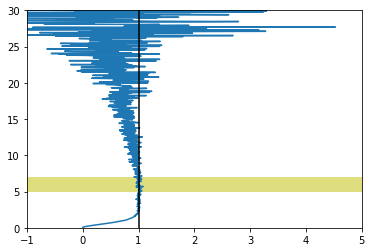

In [333]:
gif, ax2 = plt.subplots()
ax2.plot(sr30, z30) 
ax2.vlines(1, ymin=z30.min(), ymax=z30.max(), color='k', zorder = 10)
ax2.axhspan(new1.attrs['calibration height'][0]/1e3, new1.attrs['calibration height'][1]/1e3, color='y', alpha=0.5, lw=0, label='calibration height')
ax2.set_xlim(-1,5)
ax2.set_ylim(0, 30)


### IPRAL

In [1]:
### IMPORT FUNCTIONS FOR SIMULATE MOLECULAR SIGNAL AND FOR FILTER CLOUD
import sys
sys.path.append('/homedata/nmpnguyen/ipral-tools/')
from imp import reload as rl
# rl(ipral_chm15k_cloud_filter)
from ipral_chm15k_cloud_filter import ipral_remove_cloud_profiles as cloud_filter
# rl(ipral_variables_simulation)
from ipral_variables_simulation import simulate 

In [4]:
###____Ajouter le filtrage des nuages avant la lecture 
ipralpath = Path('/bdd/SIRTA/pub/basesirta/1a/ipral/2018/09/29/ipral_1a_Lz1R15mF30sPbck_v01_20180929_000000_1440.nc')
ipralraw = cloud_filter(date=pd.to_datetime(ipralpath.name.split('_')[4]), alt_max=4000, ipral_file=ipralpath, output=Path('/homedata/nmpnguyen/IPRAL/RF/Cloud_filter/', ipralpath.name))
signal = ipralraw['rcs_13']
bckgrd = ipralraw['bckgrd_rcs_13']
ipralrange = ipralraw['range'].values
iprcs = (signal/(ipralrange**2) - bckgrd)*(ipralrange**2)

###____Preparation Pression, Temperature et alt 
ipralsimul = simulate(Path('/homedata/nmpnguyen/IPRAL/RF/Cloud_filter/', ipralpath.name))
pression = ipralsimul['pression'].unstack(level=1)
ta = ipralsimul['ta'].unstack(level=1)

Processing 2018-09-29
Removing IPRAL profiles with clouds below  4000.0
CHM15k file found: /bdd/SIRTA/pub/basesirta/1a/chm15k/2018/09/29/chm15k_1a_z1Ppr2R15mF15s_v01_20180929_000000_1440.nc
2832 in IPRAL data
0 profiles will be remove
saving in /homedata/nmpnguyen/IPRAL/RF/Cloud_filter/ipral_1a_Lz1R15mF30sPbck_v01_20180929_000000_1440.nc
-----GET IPRAL BCK CORRECTED FILE-----
longitude: 2.25
latitude: 48.75
-----GET ERA5 FILE-----
path of temperature /bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_PL/2018/ta.201809.ap1e5.GLOBAL_025.nc
path of geopotential /bdd/ERA5/NETCDF/GLOBAL_025/hourly/AN_PL/2018/geopt.201809.ap1e5.GLOBAL_025.nc
-----CONVERT TIME AND LOCALISATION-----
Time loading 52.35571280308068
-----GETTING PRESSURE AND TEMPERATURE-----
variables_from_era --> end
-----SIMULATE ATTENUATED BACKSCATTERING FROM ERA5-----


/mnt/homedafs-2.5/lov/homedata/nmpnguyen/python_envs/ipral_tools/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


simulate_atb_mol --> end
-----BEFORE INTERPOLATE-----


  0%|          | 0/2832 [00:00<?, ?it/s]

-----INTERPOLATE ATTENUATED BACKSCATTERING FROM ERA5-----


100%|██████████| 2832/2832 [04:20<00:00, 10.86it/s]


interpolate_atb_mol --> end
output filename: /homedata/nmpnguyen/IPRAL/RF/Simul/ipral_1a_Lz1R15mF30sPbck_v01_20180929_000000_1440_simul.pkl


In [6]:
'''
Appliquer aux données Opar : nuage 21.01.2019 et ciel clair 17.06.2019
1. Calculer le profil Pr2_z0 = Pr2[z]/Pr2[z0] puis calculer la valeur de son intégrale etre zmin et zmax
'''
### Determiner z0
zbottom = 5000
ztop = 7000
Z0, idx_ref = get_altitude_reference(zbottom, ztop, ipralrange)
zintervalle = np.where((ipralrange >= zbottom) & (ipralrange <= ztop))[0]

t=30
Pr2_Z0 = iprcs.isel(time=t)/iprcs.isel(time=t, range=idx_ref)
Pr2_integ = 0; Pr2_integ_v2 = 0
for z in zintervalle[:-1]:
    Pr2_integ = Pr2_integ + Pr2_Z0.isel(range=z).values*(ipralrange[z+1]-ipralrange[z])
    Pr2_integ_v2 = Pr2_integ_v2 + iprcs.isel(range=z).values*(ipralrange[z+1]-ipralrange[z])
    
Pr2_integM = np.mean(Pr2_Z0[zintervalle].values)


In [11]:
'''
2. Calculer le profil BetaMol[z]*Tr2(AlphaMol(z))[z0] 
Et calculer son integrale entre zmin et zmax
'''

AlphaMol, BetaMol = get_backscatter_mol(pression.values, ta.values, 0.355)

BetaMol_Z0_v3, Tr_v3 = np.array(get_backscatter_mol_attn_v3(AlphaMol[t,:], BetaMol[t,:], ipralrange))
# BetaMol_Z0_v2, Tr_v2 = np.array(get_backscatter_mol_attn_v2(AlphaMol, BetaMol, ipralrange))
BetaMol_Z0, Tr = np.array(get_backscatter_mol_attn_v1(AlphaMol[t,:], BetaMol[t,:], ipralrange, idx_ref))
# f, ax = plt.subplots()
# ax.plot(BetaMol[1,:], ipralrange, label='BetaMol')
# ax.plot(BetaMol_Z0[1,:], ipralrange, label='BetaMol_Z0')

BetaMol_integ = 0
# BetaMol_integ_v2 = 0
BetaMol_integ_v3 = 0
for z in zintervalle[:-1]:
    BetaMol_integ = BetaMol_integ + BetaMol_Z0[z]*(ipralrange[z+1]-ipralrange[z]) 
#     BetaMol_integ_v2 = BetaMol_integ_v2 + BetaMol_Z0_v2[z]*(ipralrange[z+1]-ipralrange[z]) 
    BetaMol_integ_v3 = BetaMol_integ_v3 + BetaMol_Z0_v3[z]*(ipralrange[z+1]-ipralrange[z]) 

<ipython-input-11-6fddcf5af950>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  BetaMol_Z0, Tr = np.array(get_backscatter_mol_attn_v1(AlphaMol[t,:], BetaMol[t,:], ipralrange, idx_ref))


In [19]:
'''
3. Diviser l'un par l'autre pour obtenir cRF
'''
print(BetaMol_Z0.shape)
print(Pr2_integ.shape, Pr2_integ_v2.shape)
cRF = BetaMol_integ/Pr2_integ
# cRF_v2 = BetaMol_integ_v2/Pr2_integ_v2
cRF_v3 = BetaMol_integ_v3/Pr2_integ_v2
'''
4. Normaliser les profils mesures par cRF
'''
# Pr2_norm = rep1.isel(time=t)['signal'].values*cRF
Pr2_norm = Pr2_Z0.values*cRF
print(Pr2_norm)

(4000,)
() (2832,)
[-9.37075711e-10 -3.91211705e-09 -9.47150384e-09 ...  7.96076152e-04
  7.96474461e-04  7.96872827e-04]


In [298]:
'''
7. Sortir en NetCDF
'''
new_nc = opar.copy()
print(Pr2_norm.shape)
# print(new_nc.sel(channel= '00532.p', time=1)['signal'].shape)
new_nc["signal"].isel(channel='')


(16380,)


<xarray.Dataset>
Dimensions:     (channel: 9, new_signal: 16380, range: 16380, time: 134)
Coordinates:
  * time        (time) datetime64[ns] 2019-01-16T15:51:51 ... 2019-01-16T20:2...
  * range       (range) float64 0.0 0.0075 0.015 0.0225 ... 122.8 122.8 122.8
  * channel     (channel) object '00289.o' '00289.o' ... '00532.s' '00607.o'
  * new_signal  (new_signal) float64 0.0 2.146e-11 ... 2.348e-06 1.335e-06
Data variables:
    signal      (time, range, channel) float64 ...

Text(0.5, 0.98, 'zmin = 5000, zmax = 7000, z0 = 6000.0')

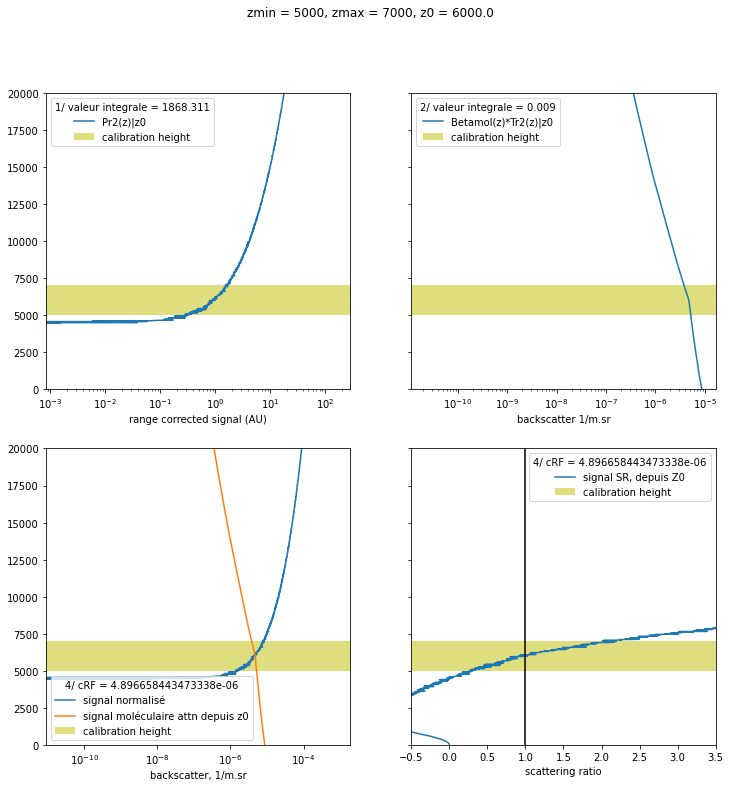

In [25]:
# '''
# 5. Plot un profil normalisé et moléculaire
# '''
fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=[12,12], sharey=True)#

ax.semilogx(Pr2_Z0.values[:len(ipralrange)], ipralrange, label='Pr2(z)|z0')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
leg = ax.legend()
leg.set_title(f'1/ valeur integrale = {round(Pr2_integ,3)}')
ax.set(xlabel='range corrected signal (AU)')
ax.set_ylim(0, 20000)
# ax.set_xlim(1e-1, 2)

ax2.semilogx(BetaMol_Z0, ipralrange, label='Betamol(z)*Tr2(z)|z0')
ax2.set(xlabel='backscatter 1/m.sr')
ax2.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
leg2 = ax2.legend()
leg2.set_title(f'2/ valeur integrale = {round(BetaMol_integ,3)}')
# ax2.set_xlim(1e-8, 2e-6)

ax3.semilogx(Pr2_norm[:len(ipralrange)], ipralrange, label='signal normalisé')
ax3.semilogx(BetaMol_Z0, ipralrange, label='signal moléculaire attn depuis z0')
# ax3.semilogx(BetaMol_Z0_v2, ipralrange, label='signal moleculaire attn depuis sol')
ax3.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
# ax.set(title='5.916e-11')
leg3 = ax3.legend()
leg3.set_title(f'4/ cRF = {cRF}')
ax3.set(xlabel='backscatter, 1/m.sr')
# ax3.set_xlim(1e-8, 2e-6)

ax4.plot(Pr2_norm[:len(ipralrange)]/BetaMol_Z0, ipralrange, label='signal SR, depuis Z0')
# ax4.plot(Pr2_norm[:len(ipralrange)]/BetaMol_Z0_v2, ipralrange, label='signal SR, depuis sol')
ax4.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax4.vlines(1, ymin=ipralrange.min(), ymax=ipralrange.max(), color='k', zorder=10)
# ax.set(title='5.916e-11')
leg4 = ax4.legend()
leg4.set_title(f'4/ cRF = {cRF}')
ax4.set_xlim(-0.5, 3.5)
ax4.set(xlabel = 'scattering ratio')

plt.suptitle(f'zmin = {zbottom}, zmax = {ztop}, z0 = {ipralrange[idx_ref]}')

In [5]:
### Ouvrir le fichier des jours sélectionés
with open('/homedata/nmpnguyen/ipral-tools/ClearSkyIprallist.txt', 'r') as f:
    all_data = [line.strip() for line in f.readlines()]
    
metadata_line = all_data[:4]
listdays = all_data[4:]


In [22]:
fig, (ax,ax6, ax9) = plt.subplots(nrows=1, ncols=3, figsize=[12,6], sharey=True)

ax.semilogx(AlphaMol[ipralrange<20000], ipralrange[ipralrange<20000], label='extinction Rayleigh')
ax.semilogx(AlphaMol[ipralrange<20000]*2, ipralrange[ipralrange<20000], label='extinction Rayleigh+Mie')
# ax.semilogx(BetaMol[opalt<20000], opalt[opalt<20000], label='molecular backscatter')
ax.set_ylim(0, 20000)
ax.legend(loc='best', frameon=False)

ax6.plot(Tr, ipralrange[idx_ref:], label='Beta apparent')
ax6.plot(Tr_v2[ipralrange<20000], ipralrange[ipralrange<20000], label='molecular extinction+Mie')
ax6.plot(Tr_v3[ipralrange<20000], ipralrange[ipralrange<20000], label='standard')
ax6.axhline(y=ipralrange[idx_ref])
# ax6.plot(Pr2_norm[opalt<20000]/BetaMol_Z0[opalt<20000], opalt[opalt<20000], label='signal Calibrated by Beta apperant')
# ax6.plot(Pr2_norm_v2[opalt<20000]/BetaMol_Z0_v2[opalt<20000], opalt[opalt<20000], label='signal Calibrated by \nextinction Rayleigh+Mie')
# ax6.vlines(1, ymin=opalt.min(), ymax=opalt.max(), color='k', zorder=10)
ax6.legend(loc='best', frameon=False, title='AOD')
# ax6.set(xlabel = 'scattering ratio')
ax6.set_ylim(0, 20000)

ax9.semilogx(BetaMol_Z0[ipralrange<20000], ipralrange[ipralrange<20000], label='par Beta apparent')
ax9.semilogx(BetaMol_Z0_v2[ipralrange<20000], ipralrange[ipralrange<20000], label='par Rayleigh+Mie')
ax9.semilogx(BetaMol_Z0_v3[ipralrange<20000], ipralrange[ipralrange<20000], label='standard')
ax9.legend(loc='best', frameon=False)
ax9.set(xlabel='backscatter, 1/m.sr')


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1518 but corresponding boolean dimension is 4000

In [18]:
from pathlib import Path
ipralpath = list(Path('/bdd/SIRTA/pub/basesirta/1a/ipral/', listdays[0]).glob('ipral_1a_Lz1R15mF30sPbck_v01_*.nc'))[0]
ipralpath.name
ipralsimulpath = sorted(Path('/homedata/nmpnguyen/IPRAL/RF/').glob(ipralpath.name.split('.')[0]+'_simul.pkl'))[0]
'2020/01/01'.replace("/","")

### AIRCRAFT-ER2

In [243]:
maindir = Path('/homedata/nmpnguyen/ORACLES-ER2/')
listpaths = sorted(maindir.glob('*R8.h5'))
for er2path in listpaths:
    print(er2path)

/homedata/nmpnguyen/ORACLES-ER2/HSRL2_ER2_20160819_R8.h5
/homedata/nmpnguyen/ORACLES-ER2/HSRL2_ER2_20160823_R8.h5
/homedata/nmpnguyen/ORACLES-ER2/HSRL2_ER2_20160912_R8.h5
/homedata/nmpnguyen/ORACLES-ER2/HSRL2_ER2_20160920_R8.h5


In [276]:
er2path = Path('/homedata/nmpnguyen/ORACLES-ER2/HSRL2_ER2_20160819_R8.h5')
#er2 = xr.open_dataset(er2path)
DataProducts = xr.open_dataset(er2path, group='DataProducts')
Nav_Data = xr.open_dataset(er2path, group='Nav_Data')
State = xr.open_dataset(er2path, group='State')

In [277]:
er2alt = DataProducts['Altitude'][:].values.flatten() #phony_dim_1: 1389
time = Nav_Data['gps_time'][:].values.flatten() #phony_dim_7: 1404
print(er2alt)
print(len(time))

TT = State['Temperature'] #phony_dim_9: 1404, phony_dim_10: 1389, K
TP = State['Pressure']*101325 #phony_dim_9: 1404, phony_dim_10: 1389, atm
ND = State['Number_Density']
print(TT.shape)


[ -300.      -285.0104  -270.0208 ... 20475.5856 20490.5752 20505.5648]
1404
(1404, 1389)


In [284]:
### Determiner z0
zbottom = 17700
ztop = 19000
# Z0, idx_ref = get_altitude_reference(zbottom, ztop, er2alt)
# zintervalle = np.where((er2alt > zbottom) & (er2alt < ztop))[0]
# print(idx_ref)

interval_ref = er2alt[(er2alt >= zbottom) & (er2alt <= ztop)] 
a = interval_ref
if len(a) % 2 == 1:
    idxref = np.where(a == np.median(a))[0][0]
else:
    l,r = len(a) // 2 - 1, len(a) // 2
    left = np.partition(a, l)[l]
    right = np.partition(a, r)[r]
    idxref = np.where(a == left)[0][0]

# idxref = arg_median(interval_ref)
zref = interval_ref[idxref]
idxref_in_total = np.where(er2alt == zref)[0][0]
print(idxref)

43


In [247]:
# '''
# 2. Calculer le profil BetaMol[z]*Tr2(AlphaMol(z))[z0] 
# Et calculer son integrale entre zmin et zmax
# '''
# def get_backscatter_mol(p, T, w):
#     '''
#     Fonction permet de calculer le coef. de backscatter moléculaire 
#     p(Pa), T(K), w(um)
#     '''
#     k = 1.38e-23
#     betamol = (p/(k*T) * 5.45e-32 * (w/0.55)**(-4.09))
#     alphamol = betamol/0.119
#     return alphamol, betamol

pres = pression.iloc[t,:].values
temp = ta.iloc[t,:].values
AlphaMol, BetaMol = get_backscatter_mol(pres, temp, 0.532)
print(BetaMol)


# def get_backscatter_mol_attn_v1(alphamol, betamol, alt, idxref):
#     '''
#     Cette fonction permet de calculer la retrodiffusion attenuee à partir de zref 
#     '''
#     Tr = betamol[idxref:].copy() #np.zeros_like(BetaMol[idx_ref:])
#     Tr2 = np.zeros_like(betamol[idxref:])
#     print(len(Tr), len(Tr2))

#     for i,j in zip(range(1, len(Tr2)),range(idxref+1, len(alt))):
#         Tr[i] = Tr[i-1] + alphamol[i]*(alt[j]-alt[j-1])
#         Tr2[i] = np.exp(-2*Tr[i])

#     betamol_Z0 = betamol.copy() #np.ones_like(BetaMol)   
#     betamol_Z0[idxref+1:] = betamol[idxref+1:]*Tr2[1:]
# #     print(betamol_Z0[idxref])  
#     return betamol_Z0


# def get_backscatter_mol_attn_v2(alphamol, betamol, alt):
#     '''
#     Cette fonction permet de calculer la retrodiffusion attenuee à partir de l'altitude de l'instrument
#     '''
#     Tr = np.zeros_like(betamol)
#     Tr2 = np.zeros_like(betamol)
    
#     for i in range(1, len(Tr)):
#         Tr[i] = Tr[i-1] + alphamol[i]*(alt[i]-alt[i-1])
#         Tr2[i] = np.exp(-2*Tr[i])
        
#     betamol_Z0 = betamol*Tr2        
#     return betamol_Z0


[ 1.24567078e-06  1.24348423e-06  1.24129759e-06 ... -1.69424112e-07
 -1.69436429e-07 -1.69448747e-07]


[0.79914326 0.79945765 0.79977179 ... 0.99994114 0.99997049 0.        ] [1.12107525e-01 1.11910858e-01 1.11714430e-01 ... 2.94288632e-05
 1.47532930e-05 1.15901572e-07] [1.56130847e-06 1.55941198e-06 1.55751818e-06 ... 1.16506968e-07
 1.16203873e-07 1.15901572e-07]


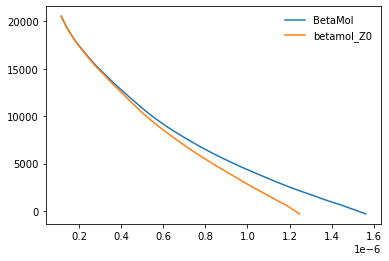

In [262]:
AlphaMol, BetaMol = get_backscatter_mol(TP.values, TT.values, 0.532)
Tr = BetaMol[:].copy()
Tr2 = np.zeros_like(BetaMol)
for i in range(len(er2alt)-2, -1, -1):
    Tr[:,i] = Tr[:, i+1] + AlphaMol[:,i]*(er2alt[i+1]-er2alt[i])
    Tr2[:,i] = np.exp(-2*Tr[:,i])
    
betamol_Z0 = BetaMol.copy()
betamol_Z0[:, 0:idx_ref] = BetaMol[:,0:idx_ref]*Tr2[:,0:idx_ref]

print(Tr2[0,:], Tr[0,:], BetaMol[0,:])
f, ax = plt.subplots()
# ax.plot(Tr2[0,:], er2alt, label='Tr2')
# ax.plot(Tr[0,:], er2alt, label='Tr')
ax.plot(BetaMol[0,:], er2alt, label='BetaMol')
ax.plot(betamol_Z0[0,:], er2alt, label='betamol_Z0')
ax.legend(loc='best', frameon=False)
# BetaMol_Z0_v2 = np.array([get_backscatter_mol_attn_v2(AlphaMol[i,:], BetaMol[i,:], er2alt) for i in range(len(time))])
# BetaMol_Z0 = np.array([get_backscatter_mol_attn_v1(AlphaMol[i,:], BetaMol[i,:], er2alt, idx_ref) for i in range(len(time))])

In [263]:
BetaMol_integ = np.zeros(len(time))
for z in zintervalle[:-1]:
    BetaMol_integ = BetaMol_integ + betamol_Z0[:,z]*(er2alt[z+1]-er2alt[z]) 
print(BetaMol_integ)

[0.00021929 0.0002193  0.0002193  ... 0.00022    0.00022    0.00022   ]


In [264]:
er2attn532 = DataProducts["532_total_attn_bsc"].values
er2attn355 = DataProducts["355_total_attn_bsc"].values
# print(DataProducts["532_total_attn_bsc"])

Pr2_integ = np.zeros(len(time))
for z in zintervalle[:-1]:
    Pr2_integ = Pr2_integ + er2attn532[:,z]*(er2alt[z+1]-er2alt[z])
    

In [265]:
cRF = (BetaMol_integ/Pr2_integ).reshape(-1,1)
# Pr2_norm = er2attn532*cRF
BetaMol_Z0norm = betamol_Z0/cRF

(0.0, 20000.0)

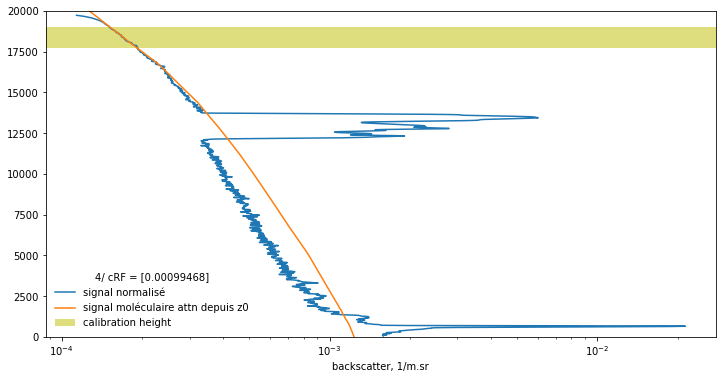

In [266]:
fig, ax3 = plt.subplots(nrows=1, ncols=1, figsize=[12,6], sharey=True)#
n=1040
ax3.semilogx(er2attn532[n,:len(er2alt)], er2alt, label='signal normalisé')
ax3.semilogx(BetaMol_Z0norm[n,:], er2alt, label='signal moléculaire attn depuis z0')
# ax3.semilogx(BetaMol_Z0_v2[n,:], ipralrange, label='signal moleculaire attn depuis sol')
ax3.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
leg3 = ax3.legend(loc='best', frameon=False)
leg3.set_title(f'4/ cRF = {cRF[n]}')
ax3.set(xlabel='backscatter, 1/m.sr')
ax3.set_ylim(0, 20000)


Text(0.5, 0.98, '/homedata/nmpnguyen/ORACLES-ER2/HSRL2_ER2_20160823_R8.h5\n time:4.930833333333334')

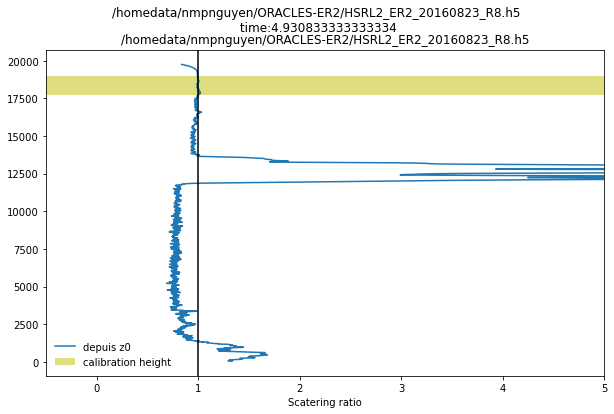

In [198]:
f, ax =plt.subplots(figsize=[10,6])
ax.plot(er2attn532[n,:len(er2alt)]/BetaMol_Z0norm[n,:], er2alt, label='depuis z0')
ax.axvline(x=1, color='k')
ax.axhspan(zbottom, ztop, color='y', alpha=0.5, lw=0, label='calibration height')
ax.set(xlabel='Scatering ratio', title=er2path)
ax.legend(loc='best', frameon=False)
ax.set_xlim(-.5, 5)
plt.suptitle(f'{er2path}\n time:{time[n]}')

In [254]:
residus = np.zeros(len(time))
for t in range(1, len(er2alt)):
    residus = residus + np.nansum([er2attn532[:,t],-BetaMol_Z0norm[:,t]], axis=0)*(er2alt[t]-er2alt[t-1])

In [70]:
new = xr.open_dataset('/homedata/nmpnguyen/ORACLES-ER2/RF/Calibrated/HSRL2_ER2_20160823_R8.h5')
new

# # residus = []
# # for pathfile in list_files:
# #     data = xr.open_dataset(pathfile)
# residual = np.zeros(len(new['time']))
# for z in range(len(new['range'])):
#     residual = residual + np.nansum(new['calibrated'][0,:,z] - new['molecular'][0,:,z])

# #     residus.append(residual)


<xarray.Dataset>
Dimensions:     (altitude: 1391, time: 1651, wavelength: 2)
Coordinates:
  * time        (time) float64 1.926 1.929 1.932 1.934 ... 6.592 6.595 6.598
  * altitude    (altitude) float64 -300.0 -285.0 -270.0 ... 2.052e+04 2.054e+04
  * wavelength  (wavelength) int64 355 532
Data variables:
    calibrated  (wavelength, time, altitude) float64 ...
    molecular   (wavelength, time, altitude) float64 ...

(0.0, 3.5)

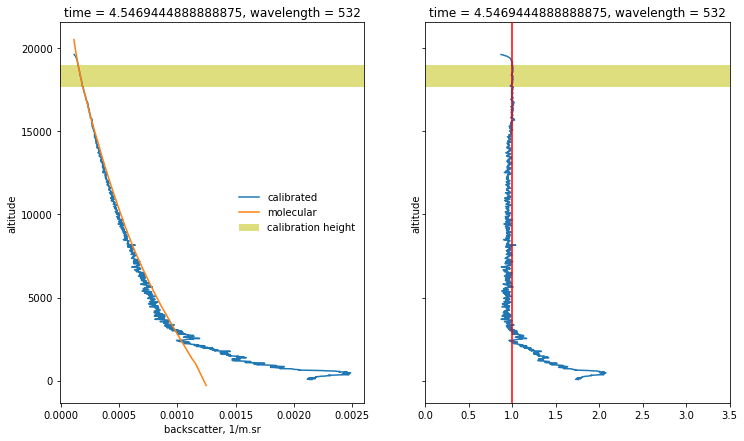

In [73]:
fig, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize=[12,7], sharey=True)#
n=920
new.isel(wavelength=1, time=n)['calibrated'].plot(y='altitude', ax=ax3, label='calibrated')
new.isel(wavelength=1, time=n)['molecular'].plot(y='altitude', ax=ax3, label='molecular')
ax3.axhspan(17700, 19000, color='y', alpha=0.5, lw=0, label='calibration height')
leg3 = ax3.legend(loc='best', frameon=False)
ax3.set(xlabel='backscatter, 1/m.sr')


(new.isel(wavelength=1, time=n)['calibrated']/new.isel(wavelength=1, time=n)['molecular']).plot(y='altitude', ax=ax4, label='sr')
ax4.axvline(1, zorder=10, color='r')
ax4.axhspan(17700, 19000, color='y', alpha=0.5, lw=0, label='calibration height')
ax4.set_xlim(0, 3.5)

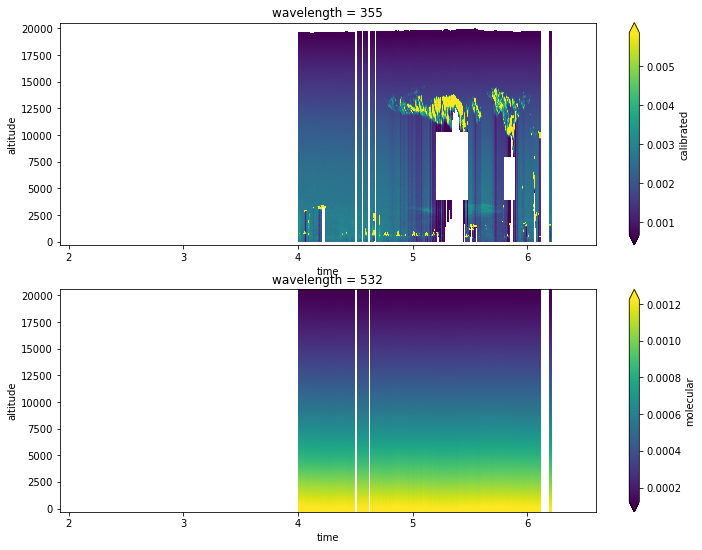

In [55]:
f, (ax, ax1) = plt.subplots(nrows=2, figsize=[12,9])
new.isel(wavelength=0)['calibrated'].plot(x='time', y='altitude', robust=True, ax=ax)
new.isel(wavelength=1)['molecular'].plot(x='time', y='altitude', robust=True, ax=ax1)